# Overview

Processing of data from 97 subjects who completed the Unique Corporate Association Valence task. In this task, particpants were provided different colored shirts and cars and were subsequently asked to list three unique associations regarding each image.

Additionally, subjects were asked to rate each of these associations on a subjective scale of -3 to +3

Prior to this, subjects had indicated their preferences for these objects over the course of 5 repeated measurements, spanning a month. 

The purpose of this document is to understand if there is any relationship between association valence and instability in preferences.

https://www.researchgate.net/publication/247478798_Assessing_the_corporate_brand_The_Unique_Corporate_Association_Valence_UCAV_approach

# Initial Reqs

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from math import pi
from itertools import combinations_with_replacement
import pickle
from IPython.display import display
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
from natsort import natsorted
import seaborn as sns
import scipy.stats as stats 
from collections import Counter
from itertools import groupby
from operator import itemgetter
from itertools import combinations
import time
import datetime
import choix
import plotly.graph_objects as go
from tqdm import tqdm
import glob
import natsort
from tabulate import tabulate
from scipy.spatial import distance

# Load subjects

In [75]:
finalSubs=['sub'+str(i) for i in np.arange(1,97)]

In [2]:
finalSubs=['sub'+str(i) for i in np.concatenate([np.arange(1,84),np.arange(85,97)])]#removed 84 which is random


os.chdir(r"C:\Users\al33m\Box\Grzywacz Lab\Experiment\age_DataFiles\final\pickle")
#subject class for loading
class Subject():
    def __init__(self,subname):
        self.subname=subname
#load
Subs={}
for i in tqdm(finalSubs):
    with open(i+'.pkl', 'rb') as input:
        Subs[i] = pickle.load(input)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:09<00:00, 10.06it/s]


# Process Qualtrics Data

## read excel

In [3]:
qualtrics_AGE=pd.read_excel(r"C:\Users\al33m\Box\Grzywacz Lab\Experiment\age_DataFiles\Rfiles\All_Ratings_Associations - V2_May 17, 2021_12.39.xlsx",header=None)

In [4]:
qualtrics_AGE.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,2021-05-06 15:02:10,2021-05-06 15:31:04,IP Address,151.32.104.105,100,1733,True,2021-05-06 15:31:04.843,R_3QEouX9aRanmnA8,NaN,NaN,NaN,NaN,45.091400,7.663895,anonymous,EN,Yes I have met these requirements,5b98bdebd3ccc00001fea097,91,live,energetic,positive,Positive,Positive,Positive,72,sad,flat,monotone,Slightly Negative,Slightly Negative,Slightly Negative,71.0,flat,monotone,dull,Slightly Negative,Neutral,Slightly Negative,81,regular,monotonous,normal,Slightly Positive,Slightly Negative,Neutral,91,nice,elegant,interesting,Positive,Slightly Positive,Slightly Positive,82,live,positive,cherful,Positive,Very Positive,Positive,82,nice,hospitable,interesting,Positive,Positive,Positive,72.0,normal,valid,bright,Positive,Slightly Positive,Slightly Positive,...,off,ugly,sad,Slightly Negative,Slightly Negative,Slightly Negative,92.0,bright,lively,fun,Positive,Positive,Positive,92.0,charge,movement,energy,Positive,Positive,Very Positive,82.0,off,unsuitable,serious,Negative,Slightly Negative,Neutral,82.0,sad,embarassing,gray,Negative,Negative,Negative,82.0,lively,welcoming,bright,Slightly Positive,Slightly Positive,Positive,82.0,elegant,serius,respectable,Slightly Positive,Slightly Positive,Slightly Positive,Not at all,Not at all,Not at all,Not at all,Not at all,Several days,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,I have copied the completion code,"very, very interesting!!!"
1,2021-05-06 15:15:52,2021-05-06 15:33:40,IP Address,46.208.140.36,100,1068,True,2021-05-06 15:33:41.502,R_31R9zmSlwC320S1,NaN,NaN,NaN,NaN,51.979599,-0.223801,anonymous,EN,Yes I have met these requirements,5f5a14224848f606446bbca8,71,Normal,Bright,blood,Positive,Negative,Slightly Negative,20,autumn,warning,terracotta,Neutral,Negative,Neutral,50.0,Mustard,Bright,Sun,Negative,Negative,Neutral,30,Green,Bold,Unusual,Very Negative,Very Negative,Very Negative,9,Leaves,Grass,Bold,Neutral,Neutral,Very Negative,9,Forest,Bright,Bold,Slightly Positive,Very Negative,Very Negative,9,Grass,Bold,field,Neutral,Very Negative,Slightly Negative,9.0,Ocean,Bold,Unusual,Negative,Very Negative,Very Negative,...,average,relaxed,sky,Slightly Positive,Slightly Positive,Neutral,9.0,football,uniform,bold,Negative,Negative,Very Negative,9.0,sport,sky,ocean,Neutral,Neutral,Neutral,9.0,lavender,feminine,night,Neutral,Slightly Negative,Neutral,10.0,witch,girly,feminine,Negative,Very Negative,Slightly Negative,19.0,glasses,feminine,heather,Neutral,Slightly Negative,Slightly Positive,50.0,blood,university,sport,Negative,Neutral,Neutral,Over half the days,Several days,Several days,Several days,Several days,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Several days,Not at all,Several days,Several days,Not at all,Several days,Not at all,I have copied the completion code,none
2,2021-05-06 15:00:27,2021-05-06 15:35:47,IP Address,85.164.87.183,100,2120,True,2021-05-06 15:35:48.432,R_AnXrNqFzmsHNoe5,NaN,NaN,NaN,NaN,59.598602,11.392899,anonymous,EN,Yes I have met these requirements,5dcd4c51b0649701be29751f,81,Ferrari,Blood,Dress,Very Positive,Neutral,Very Positive,10,Dirt,aunt,ant,Very Negative,Very Positive,Negative,0.0,autumn,Toilet,Gail,Slightly Positive,Negative,Negative,10,Muppet,Frog,grandmother,Positive,Negative,Very Positive,0,Gra

In [5]:
np.shape(qualtrics_AGE)

(54, 256)

In [6]:
qualtrics_AGE.drop(qualtrics_AGE.columns[0:18],axis=1,inplace=True)#drop misc questions
qualtrics_AGE.drop(qualtrics_AGE.columns[236:238],axis=1,inplace=True)#drop last two questions (completion code)
qualtrics_AGE.dropna(thresh=3,inplace=True)#drop empty rows
qualtrics_AGE.reset_index(drop=True,inplace=True)

In [7]:
qualtrics_AGE.head()

,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,...,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253
0,5b98bdebd3ccc00001fea097,91,live,energetic,positive,Positive,Positive,Positive,72,sad,flat,monotone,Slightly Negative,Slightly Negative,Slightly Negative,71.0,flat,monotone,dull,Slightly Negative,Neutral,Slightly Negative,81,regular,monotonous,normal,Slightly Positive,Slightly Negative,Neutral,91,nice,elegant,interesting,Positive,Slightly Positive,Slightly Positive,82,live,positive,cherful,Positive,Very Positive,Positive,82,nice,hospitable,interesting,Positive,Positive,Positive,72.0,normal,valid,bright,Positive,Slightly Positive,Slightly Positive,62.0,blu sky,quite,serius,Positive,Slightly Positive,Slightly Positive,82,exciting,fast,positive,Positive,Positive,Positive,81.0,pleasant,live,open,...,Slightly Positive,72.0,off,ugly,sad,Slightly Negative,Slightly Negative,Slightly Negative,92.0,bright,lively,fun,Positive,Positive,Positive,92.0,charge,movement,energy,Positive,Positive,Very Positive,82.0,off,unsuitable,serious,Negative,Slightly Negative,Neutral,82.0,sad,embarassing,gray,Negative,Negative,Negative,82.0,lively,welcoming,bright,Slightly Positive,Slightly Positive,Positive,82.0,elegant,serius,respectable,Slightly Positive,Slightly Positive,Slightly Positive,Not at all,Not at all,Not at all,Not at all,Not at all,Several days,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all
1,5f5a14224848f606446bbca8,71,Normal,Bright,blood,Positive,Negative,Slightly Negative,20,autumn,warning,terracotta,Neutral,Negative,Neutral,50.0,Mustard,Bright,Sun,Negative,Negative,Neutral,30,Green,Bold,Unusual,Very Negative,Very Negative,Very Negative,9,Leaves,Grass,Bold,Neutral,Neutral,Very Negative,9,Forest,Bright,Bold,Slightly Positive,Very Negative,Very Negative,9,Grass,Bold,field,Neutral,Very Negative,Slightly Negative,9.0,Ocean,Bold,Unusual,Negative,Very Negative,Very Negative,51.0,Sky,Stationery,Sea,Slightly Positive,Slightly Positive,Slightly Positive,51,Sky,Average,Sea,Slightly Positive,Slightly Positive,Slightly Positive,19.0,Night,Bright,Bold,...,Slightly Negative,40.0,average,relaxed,sky,Slightly Positive,Slightly Positive,Neutral,9.0,football,uniform,bold,Negative,Negative,Very Negative,9.0,sport,sky,ocean,Neutral,Neutral,Neutral,9.0,lavender,feminine,night,Neutral,Slightly Negative,Neutral,10.0,witch,girly,feminine,Negative,Very Negative,Slightly Negative,19.0,glasses,feminine,heather,Neutral,Slightly Negative,Slightly Positive,50.0,blood,university,sport,Negative,Neutral,Neutral,Over half the days,Several days,Several days,Several days,Several days,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Several days,Not at all,Several days,Several days,Not at all,Several days,Not at all
2,5dcd4c51b0649701be29751f,81,Ferrari,Blood,Dress,Very Positive,Neutral,Very Positive,10,Dirt,aunt,ant,Very Negative,Very Positive,Negative,0.0,autumn,Toilet,Gail,Slightly Positive,Negative,Negative,10,Muppet,Frog,grandmother,Positive,Negative,Very Positive,0,Grass,Leaves,forest,Very Positive,Very Positive,Very Positive,10,Forest,Leaves,Bright,Positive,Positive,Neutral,9,Forest,leaves,grass,Very Positive,Very Positive,Very Positive,0.0,Sea,Water,Coast,Very Positive,Very Positive,Very Positive,78.0,Family,Sky,Calm,Very Positive,Positive,Positive,9,Brother,Sky,Sea,Very Positive,Very Positive,V

In [9]:
np.shape(qualtrics_AGE)

(54, 236)

### name columns

In [12]:
ratingQs=['rate','word1','word2','word3','val1','val2','val3']


In [13]:
carRatingQs=[]
shirtRatingQs=[]
for i in np.arange(1,16):
    carRatingQs.append(['car'+str(i)+'_'+d for d in ratingQs ])
    shirtRatingQs.append(['shirt'+str(i)+'_'+d for d in ratingQs])
carRatingQs=[item for sublist in carRatingQs for item in sublist]
shirtRatingQs=[item for sublist in shirtRatingQs for item in sublist]

In [14]:
paranoiaQs=['GTP'+str(i) for i in np.arange(1,19)]

In [15]:
gadQs=['GAD'+str(i) for i in np.arange(1,8)]

In [16]:
myColNames=['prolificID']+carRatingQs+shirtRatingQs+paranoiaQs+gadQs

In [17]:
qualtrics_AGE.columns=myColNames

In [18]:
qualtrics_AGE.head()

,prolificID,car1_rate,car1_word1,car1_word2,car1_word3,car1_val1,car1_val2,car1_val3,car2_rate,car2_word1,car2_word2,car2_word3,car2_val1,car2_val2,car2_val3,car3_rate,car3_word1,car3_word2,car3_word3,car3_val1,car3_val2,car3_val3,car4_rate,car4_word1,car4_word2,car4_word3,car4_val1,car4_val2,car4_val3,car5_rate,car5_word1,car5_word2,car5_word3,car5_val1,car5_val2,car5_val3,car6_rate,car6_word1,car6_word2,car6_word3,car6_val1,car6_val2,car6_val3,car7_rate,car7_word1,car7_word2,car7_word3,car7_val1,car7_val2,car7_val3,car8_rate,car8_word1,car8_word2,car8_word3,car8_val1,car8_val2,car8_val3,car9_rate,car9_word1,car9_word2,car9_word3,car9_val1,car9_val2,car9_val3,car10_rate,car10_word1,car10_word2,car10_word3,car10_val1,car10_val2,car10_val3,car11_rate,car11_word1,car11_word2,car11_word3,...,shirt8_val3,shirt9_rate,shirt9_word1,shirt9_word2,shirt9_word3,shirt9_val1,shirt9_val2,shirt9_val3,shirt10_rate,shirt10_word1,shirt10_word2,shirt10_word3,shirt10_val1,shirt10_val2,shirt10_val3,shirt11_rate,shirt11_word1,shirt11_word2,shirt11_word3,shirt11_val1,shirt11_val2,shirt11_val3,shirt12_rate,shirt12_word1,shirt12_word2,shirt12_word3,shirt12_val1,shirt12_val2,shirt12_val3,shirt13_rate,shirt13_word1,shirt13_word2,shirt13_word3,shirt13_val1,shirt13_val2,shirt13_val3,shirt14_rate,shirt14_word1,shirt14_word2,shirt14_word3,shirt14_val1,shirt14_val2,shirt14_val3,shirt15_rate,shirt15_word1,shirt15_word2,shirt15_word3,shirt15_val1,shirt15_val2,shirt15_val3,GTP1,GTP2,GTP3,GTP4,GTP5,GTP6,GTP7,GTP8,GTP9,GTP10,GTP11,GTP12,GTP13,GTP14,GTP15,GTP16,GTP17,GTP18,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
0,5b98bdebd3ccc00001fea097,91,live,energetic,positive,Positive,Positive,Positive,72,sad,flat,monotone,Slightly Negative,Slightly Negative,Slightly Negative,71.0,flat,monotone,dull,Slightly Negative,Neutral,Slightly Negative,81,regular,monotonous,normal,Slightly Positive,Slightly Negative,Neutral,91,nice,elegant,interesting,Positive,Slightly Positive,Slightly Positive,82,live,positive,cherful,Positive,Very Positive,Positive,82,nice,hospitable,interesting,Positive,Positive,Positive,72.0,normal,valid,bright,Positive,Slightly Positive,Slightly Positive,62.0,blu sky,quite,serius,Positive,Slightly Positive,Slightly Positive,82,exciting,fast,positive,Positive,Positive,Positive,81.0,pleasant,live,open,...,Slightly Positive,72.0,off,ugly,sad,Slightly Negative,Slightly Negative,Slightly Negative,92.0,bright,lively,fun,Positive,Positive,Positive,92.0,charge,movement,energy,Positive,Positive,Very Positive,82.0,off,unsuitable,serious,Negative,Slightly Negative,Neutral,82.0,sad,embarassing,gray,Negative,Negative,Negative,82.0,lively,welcoming,bright,Slightly Positive,Slightly Positive,Positive,82.0,elegant,serius,respectable,Slightly Positive,Slightly Positive,Slightly Positive,Not at all,Not at all,Not at all,Not at all,Not at all,Several days,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all
1,5f5a14224848f606446bbca8,71,Normal,Bright,blood,Positive,Negative,Slightly Negative,20,autumn,warning,terracotta,Neutral,Negative,Neutral,50.0,Mustard,Bright,Sun,Negative,Negative,Neutral,30,Green,Bold,Unusual,Very Negative,Very Negative,Very Negative,9,Leaves,Grass,Bold,Neutral,Neutral,Very Negative,9,Forest,Bright,Bold,Slightly Positive,Very Negative,Very Negative,9,Grass,Bold,field,Neutral,Very Negative,Slightly Negative,9.0,Ocean,Bold,Unusual,Negative,Very Negative,Very Negative,51.0,Sky,Stationery,Sea,Slightly Positive,Slightly Positive,Slightly Positive,51,Sky,Average,Sea,Slightly Positive,Slightly Positive,Slightly Positive,19.0,Night,Bright,Bold,...,Slightly Negative,40.0,average,relaxed,sky,Slightly Positive,Slightly Positive,Neutral,9.0,football,uniform,bold,Negative,Negative,Very Negative,9.0,sport,sky,ocean,Neutral,Neutral,Neutral,9.0,lavender,feminine,night,Neutral,Slightly Negative,Neutral,10.0,witch,girly,feminin

## Read Excel Original

In [14]:
qualtrics_ORIG=pd.read_excel(r"C:\Users\al33m\Downloads\All_Ratings_Associations_December+31,+2020_09.39\All_Ratings_Associations_December 31, 2020_09.39.xlsx")

In [15]:
qualtrics_ORIG.drop(qualtrics_ORIG.columns[0:19],axis=1,inplace=True)#drop misc questions
qualtrics_ORIG.drop(qualtrics_ORIG.columns[236:238],axis=1,inplace=True)
# # qualtrics_ORIG.drop(0,inplace=True)
qualtrics_ORIG.dropna(thresh=3,inplace=True)#drop empty rows
qualtrics_ORIG.reset_index(drop=True,inplace=True)

In [115]:
qualtrics_ORIG.head()

,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,...,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254
0,5b09360c2971540001e3e248,95.0,fire,power,autumn,Positive,Positive,Neutral,92.0,autumn,brick,school,Slightly Positive,Neutral,Slightly Negative,70.0,dirty,sand,summer,Negative,Slightly Positive,Positive,65.0,indifferent,leaves,grass,Slightly Negative,Positive,Slightly Positive,82.0,meadow,spring,warm,Positive,Positive,Positive,82.0,happy,grass,forest,Very Positive,Positive,Very Positive,69.0,Hope,Lively,Spring,Positive,Positive,Positive,70.0,water,cold,winter,Positive,Neutral,Slightly Positive,83.0,seaside,sky,ice,Positive,Positive,Neutral,82.0,seaside,evening,sky,Positive,Positive,Positive,69.0,sky,cold,winter,...,Neutral,67.0,deep,sea,sky,Neutral,Positive,Positive,66.0,evening,storm,sky,Positive,Very Positive,Positive,65.0,evening,storm,sky,Positive,Positive,Slightly Positive,52.0,too visible,flowers,girly,Neutral,Neutral,Neutral,41.0,flowers,too girly,sweetshop,Neutral,Neutral,Neutral,41.0,sweetness,girly,flower,Neutral,Neutral,Neutral,65.0,blood,autumn,leaves,Slightly Negative,Slightly Positive,Slightly Positive,Click to write Scale Point 2,Click to write Scale Point 3,Not at all,Click to write Scale Point 2,Click to write Scale Point 2,Not at all,Totally,Click to write Scale Point 2,Click to write Scale Point 2,Not at all,Click to write Scale Point 3,Not at all,Not at all,Click to write Scale Point 2,Not at all,Click to write Scale Point 2,Click to write Scale Point 2,Click to write Scale Point 2,Several days,Several days,Several days,Over half the days,Not at all,Over half the days,Several days
1,5f3a76043bb11c6786e731bf,73.0,father,mother,family,Positive,Very Positive,Slightly Positive,13.0,orange,brown,rich,Neutral,Neutral,Positive,38.0,mustard,Lexus,exotic,Slightly Negative,Positive,Neutral,31.0,old,used,broken,Slightly Negative,Negative,Negative,40.0,hometown,shop,grass,Positive,Slightly Positive,Slightly Positive,26.0,rare,innovative,trees,Positive,Slightly Positive,Very Positive,10.0,weird,childish,date,Positive,Very Positive,Slightly Negative,10.0,ugly,unusual,new,Slightly Negative,Slightly Positive,Positive,90.0,dull,cool,trustworthy,Slightly Negative,Positive,Positive

In [16]:
qualtrics_ORIG.columns=myColNames

## Combine

In [18]:
qualtrics=pd.concat([qualtrics_ORIG,qualtrics_AGE])
qualtrics.reset_index(drop=True,inplace=True)

In [19]:
qualtrics.head()

,prolificID,car1_rate,car1_word1,car1_word2,car1_word3,car1_val1,car1_val2,car1_val3,car2_rate,car2_word1,car2_word2,car2_word3,car2_val1,car2_val2,car2_val3,car3_rate,car3_word1,car3_word2,car3_word3,car3_val1,car3_val2,car3_val3,car4_rate,car4_word1,car4_word2,car4_word3,car4_val1,car4_val2,car4_val3,car5_rate,car5_word1,car5_word2,car5_word3,car5_val1,car5_val2,car5_val3,car6_rate,car6_word1,car6_word2,car6_word3,car6_val1,car6_val2,car6_val3,car7_rate,car7_word1,car7_word2,car7_word3,car7_val1,car7_val2,car7_val3,car8_rate,car8_word1,car8_word2,car8_word3,car8_val1,car8_val2,car8_val3,car9_rate,car9_word1,car9_word2,car9_word3,car9_val1,car9_val2,car9_val3,car10_rate,car10_word1,car10_word2,car10_word3,car10_val1,car10_val2,car10_val3,car11_rate,car11_word1,car11_word2,car11_word3,...,shirt8_val3,shirt9_rate,shirt9_word1,shirt9_word2,shirt9_word3,shirt9_val1,shirt9_val2,shirt9_val3,shirt10_rate,shirt10_word1,shirt10_word2,shirt10_word3,shirt10_val1,shirt10_val2,shirt10_val3,shirt11_rate,shirt11_word1,shirt11_word2,shirt11_word3,shirt11_val1,shirt11_val2,shirt11_val3,shirt12_rate,shirt12_word1,shirt12_word2,shirt12_word3,shirt12_val1,shirt12_val2,shirt12_val3,shirt13_rate,shirt13_word1,shirt13_word2,shirt13_word3,shirt13_val1,shirt13_val2,shirt13_val3,shirt14_rate,shirt14_word1,shirt14_word2,shirt14_word3,shirt14_val1,shirt14_val2,shirt14_val3,shirt15_rate,shirt15_word1,shirt15_word2,shirt15_word3,shirt15_val1,shirt15_val2,shirt15_val3,GTP1,GTP2,GTP3,GTP4,GTP5,GTP6,GTP7,GTP8,GTP9,GTP10,GTP11,GTP12,GTP13,GTP14,GTP15,GTP16,GTP17,GTP18,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
0,5b09360c2971540001e3e248,95.0,fire,power,autumn,Positive,Positive,Neutral,92.0,autumn,brick,school,Slightly Positive,Neutral,Slightly Negative,70.0,dirty,sand,summer,Negative,Slightly Positive,Positive,65.0,indifferent,leaves,grass,Slightly Negative,Positive,Slightly Positive,82.0,meadow,spring,warm,Positive,Positive,Positive,82.0,happy,grass,forest,Very Positive,Positive,Very Positive,69.0,Hope,Lively,Spring,Positive,Positive,Positive,70.0,water,cold,winter,Positive,Neutral,Slightly Positive,83.0,seaside,sky,ice,Positive,Positive,Neutral,82.0,seaside,evening,sky,Positive,Positive,Positive,69.0,sky,cold,winter,...,Neutral,67.0,deep,sea,sky,Neutral,Positive,Positive,66.0,evening,storm,sky,Positive,Very Positive,Positive,65.0,evening,storm,sky,Positive,Positive,Slightly Positive,52.0,too visible,flowers,girly,Neutral,Neutral,Neutral,41.0,flowers,too girly,sweetshop,Neutral,Neutral,Neutral,41.0,sweetness,girly,flower,Neutral,Neutral,Neutral,65.0,blood,autumn,leaves,Slightly Negative,Slightly Positive,Slightly Positive,Click to write Scale Point 2,Click to write Scale Point 3,Not at all,Click to write Scale Point 2,Click to write Scale Point 2,Not at all,Totally,Click to write Scale Point 2,Click to write Scale Point 2,Not at all,Click to write Scale Point 3,Not at all,Not at all,Click to write Scale Point 2,Not at all,Click to write Scale Point 2,Click to write Scale Point 2,Click to write Scale Point 2,Several days,Several days,Several days,Over half the days,Not at all,Over half the days,Several days
1,5f3a76043bb11c6786e731bf,73.0,father,mother,family,Positive,Very Positive,Slightly Positive,13.0,orange,brown,rich,Neutral,Neutral,Positive,38.0,mustard,Lexus,exotic,Slightly Negative,Positive,Neutral,31.0,old,used,broken,Slightly Negative,Negative,Negative,40.0,hometown,shop,grass,Positive,Slightly Positive,Slightly Positive,26.0,rare,innovative,trees,Positive,Slightly Positive,Very Positive,10.0,weird,childish,date,Positive,Very Positive,Slightly Negative,10.0,ugly,unusual,new,Slightly Negative,Slightly Positive,Positive,90.0,dull,cool,trustworthy,Slightly Negative,Positive,Positive,100.0,sister,nice,trust,Very Positive,Positive,Positive,100.0,often,beautiful,basic,...,Positive,90.0,sky,water,swimming,Neutral,Positive,Slightly Positive,90.0,kind,attractive,bold,Very Positive,Positive,Slightly Positive,90.0,talkative,outgoing,social,Positive,Very Positive,Posit

## prolific ID

Determine the unique subject identifiers

In [20]:
prolificDict=dict(zip([Subs[i].prolificID for i in finalSubs],finalSubs))#make a dictionary to map subname and prolific ID

In [22]:
len(prolificDict)

95

Find out which ID's don't match

In [25]:
notfound=[]
found=[]
match=[]
rowname=[]
r=0
for i in qualtrics.prolificID.loc[1:]:
    r=r+1
    try:
        match.append(prolificDict[i])
        found.append(i)
        rowname.append(r)
    except:
        notfound.append(i)
        print('could not find')

could not find
could not find
could not find
could not find


In [26]:
notfound

['5e554641ab5163543d2a5e68',
 '59f8937f8a2d3d00012c17c6',
 '5ea7f7d916db531e64cb2d5f',
 '5f1a9d34ca34901c30627696']

In [27]:
qualtrics=qualtrics.loc[rowname]#grab the found rownames
qualtrics.reset_index(inplace=True,drop=True)

In [28]:
len(qualtrics.prolificID)

94

In [29]:
qualtrics.head()

,prolificID,car1_rate,car1_word1,car1_word2,car1_word3,car1_val1,car1_val2,car1_val3,car2_rate,car2_word1,car2_word2,car2_word3,car2_val1,car2_val2,car2_val3,car3_rate,car3_word1,car3_word2,car3_word3,car3_val1,car3_val2,car3_val3,car4_rate,car4_word1,car4_word2,car4_word3,car4_val1,car4_val2,car4_val3,car5_rate,car5_word1,car5_word2,car5_word3,car5_val1,car5_val2,car5_val3,car6_rate,car6_word1,car6_word2,car6_word3,car6_val1,car6_val2,car6_val3,car7_rate,car7_word1,car7_word2,car7_word3,car7_val1,car7_val2,car7_val3,car8_rate,car8_word1,car8_word2,car8_word3,car8_val1,car8_val2,car8_val3,car9_rate,car9_word1,car9_word2,car9_word3,car9_val1,car9_val2,car9_val3,car10_rate,car10_word1,car10_word2,car10_word3,car10_val1,car10_val2,car10_val3,car11_rate,car11_word1,car11_word2,car11_word3,...,shirt8_val3,shirt9_rate,shirt9_word1,shirt9_word2,shirt9_word3,shirt9_val1,shirt9_val2,shirt9_val3,shirt10_rate,shirt10_word1,shirt10_word2,shirt10_word3,shirt10_val1,shirt10_val2,shirt10_val3,shirt11_rate,shirt11_word1,shirt11_word2,shirt11_word3,shirt11_val1,shirt11_val2,shirt11_val3,shirt12_rate,shirt12_word1,shirt12_word2,shirt12_word3,shirt12_val1,shirt12_val2,shirt12_val3,shirt13_rate,shirt13_word1,shirt13_word2,shirt13_word3,shirt13_val1,shirt13_val2,shirt13_val3,shirt14_rate,shirt14_word1,shirt14_word2,shirt14_word3,shirt14_val1,shirt14_val2,shirt14_val3,shirt15_rate,shirt15_word1,shirt15_word2,shirt15_word3,shirt15_val1,shirt15_val2,shirt15_val3,GTP1,GTP2,GTP3,GTP4,GTP5,GTP6,GTP7,GTP8,GTP9,GTP10,GTP11,GTP12,GTP13,GTP14,GTP15,GTP16,GTP17,GTP18,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
0,5f3a76043bb11c6786e731bf,73.0,father,mother,family,Positive,Very Positive,Slightly Positive,13.0,orange,brown,rich,Neutral,Neutral,Positive,38.0,mustard,Lexus,exotic,Slightly Negative,Positive,Neutral,31.0,old,used,broken,Slightly Negative,Negative,Negative,40.0,hometown,shop,grass,Positive,Slightly Positive,Slightly Positive,26.0,rare,innovative,trees,Positive,Slightly Positive,Very Positive,10.0,weird,childish,date,Positive,Very Positive,Slightly Negative,10.0,ugly,unusual,new,Slightly Negative,Slightly Positive,Positive,90.0,dull,cool,trustworthy,Slightly Negative,Positive,Positive,100.0,sister,nice,trust,Very Positive,Positive,Positive,100.0,often,beautiful,basic,...,Positive,90.0,sky,water,swimming,Neutral,Positive,Slightly Positive,90.0,kind,attractive,bold,Very Positive,Positive,Slightly Positive,90.0,talkative,outgoing,social,Positive,Very Positive,Positive,50.0,friend,dissatisfaction,secret,Very Positive,Negative,Slightly Positive,82.0,jealousy,dissatisfaction,trash,Slightly Negative,Negative,Neutral,60.0,teacher,advice,dark,Slightly Positive,Slightly Positive,Neutral,28.0,fashionable,expensive,unworthy,Positive,Negative,Neutral,Click to write Scale Point 2,Click to write Scale Point 3,Click to write Scale Point 3,Totally,Click to write Scale Point 3,Click to write Scale Point 2,Click to write Scale Point 3,Click to write Scale Point 3,Click to write Scale Point 3,Not at all,Click to write Scale Point 2,Click to write Scale Point 2,Not at all,Not at all,Not at all,Not at all,Not at all,Not at all,Over half the days,Over half the days,Over half the days,Several days,Several days,Nearly every day,Over half the days
1,5acb457ce1546900019c3e6c,63.0,Fire Engine,Boring,Common,Neutral,Negative,Negative,43.0,rust,Sewage,bland,Negative,Very Negative,Slightly Negative,24.0,Baby poop,diarrhoea,dog poop,Very Negative,Very Negative,Very Negative,45.0,non-descript,baby poop,interesting,Slightly Negative,Very Negative,Slightly Positive,45.0,Vibrant,Happiness,Acid,Positive,Positive,Slightly Positive,58.0,Vibrant,Grass,Racing,Positive,Positive,Positive,33.0,Toothpaste,Mint,Washed out,Negative,Neutral,Negative,45.0,Sky,Wishy-Washy,Old car,Positive,Negative,Negative,43.0,Sky,Water,non-descript,Slightly Positive,Slightly Positive,Negative,58.0,My parents,Boring,Common,Positive,Negative,Negative,59.0,My parents,Boring,Executive,...,Positive,46.0,Rivers,non-descript,Twitt

In [30]:
qualtrics.insert(loc=0,column='subname',value=match)

### separate into ratings/survey

In [31]:
qualtrics_ratings=qualtrics.iloc[:,:212]
qualtrics_survey=qualtrics.iloc[:,212:237]

# process ratings

In [32]:
car_ratings=qualtrics_ratings[['car'+str(i)+'_rate' for i in np.arange(1,16)]]
shirt_ratings=qualtrics_ratings[['shirt'+str(i)+'_rate' for i in np.arange(1,16)]]

In [33]:
shirtMelt=shirt_ratings.melt()
shirtMelt['subnames']=np.tile(qualtrics.subname,15)

In [35]:
carMelt=car_ratings.melt()
carMelt['subnames']=np.tile(qualtrics.subname,15)

In [36]:
ratingsMelt=pd.concat([shirtMelt,carMelt])

In [37]:
ratingsMelt.drop(['variable'],axis=1,inplace=True)

In [38]:
len(ratingsMelt)

2820

In [39]:
ratingsMelt['category']=np.repeat(['shirt','car'],1410)

In [40]:
ratingsMelt['hue']=np.tile(np.repeat(np.arange(1,16),len(np.unique(qualtrics.subname))),2)

In [42]:
ratingsMelt.columns=['rating','subname','category','hue']

In [43]:
ratingsMelt['rating']=pd.to_numeric(ratingsMelt['rating'])#convert to numeric

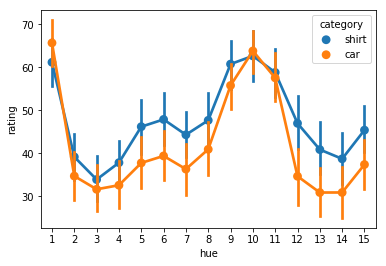

In [44]:
sns.pointplot(x='hue',y='rating',hue='category',data=ratingsMelt)

Mean rating as a function of hue

In [381]:
p=re.compile('\d+')
ratingsMelt['subnum']=[int(p.findall(i)[0]) for i in ratingsMelt['subname']]

In [385]:
ratingsMelt=ratingsMelt.sort_values(by='subnum')
ratingsMelt.reset_index(drop=True,inplace=True)

In [388]:
ratingsMelt=ratingsMelt.sort_values(by=['subnum','hue','category'])
ratingsMelt.reset_index(drop=True,inplace=True)

In [390]:
ratingsMelt=pd.concat([ratingsMelt.groupby('category').get_group('shirt'),
           ratingsMelt.groupby('category').get_group('car')])
ratingsMelt.reset_index(drop=True,inplace=True)

In [392]:
ratingsMelt.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\ratingsMelt.csv",index=False)

# process associations

In [158]:
car_vals=[]
shirt_vals=[]

for i in np.arange(1,16):
    car_vals.append(['car'+str(i)+'_val'+str(j) for j in np.arange(1,4)])
    shirt_vals.append(['shirt'+str(i)+'_val'+str(j) for j in np.arange(1,4)])

car_vals=[item for sublist in car_vals for item in sublist]
shirt_vals=[item for sublist in shirt_vals for item in sublist]

In [129]:
car_words=[]
shirt_words=[]

for i in np.arange(1,16):
    car_words.append(['car'+str(i)+'_word'+str(j) for j in np.arange(1,4)])
    shirt_words.append(['shirt'+str(i)+'_word'+str(j) for j in np.arange(1,4)])

car_words=[item for sublist in car_words for item in sublist]
shirt_words=[item for sublist in shirt_words for item in sublist]

In [130]:
valenceDict={'Very Negative':-3,
             'Negative': -2,
            'Slightly Negative': -1,
            'Neutral': 0,
            'Slightly Positive': 1,
             'Positive':2,
            'Very Positive': 3}

In [101]:
qualtrics_ratings.head()

,prolificID,car1_rate,car1_word1,car1_word2,car1_word3,car1_val1,car1_val2,car1_val3,car2_rate,car2_word1,car2_word2,car2_word3,car2_val1,car2_val2,car2_val3,car3_rate,car3_word1,car3_word2,car3_word3,car3_val1,car3_val2,car3_val3,car4_rate,car4_word1,car4_word2,car4_word3,car4_val1,car4_val2,car4_val3,car5_rate,car5_word1,car5_word2,car5_word3,car5_val1,car5_val2,car5_val3,car6_rate,car6_word1,car6_word2,car6_word3,car6_val1,car6_val2,car6_val3,car7_rate,car7_word1,car7_word2,car7_word3,car7_val1,car7_val2,car7_val3,car8_rate,car8_word1,car8_word2,car8_word3,car8_val1,car8_val2,car8_val3,car9_rate,car9_word1,car9_word2,car9_word3,car9_val1,car9_val2,car9_val3,car10_rate,car10_word1,car10_word2,car10_word3,car10_val1,car10_val2,car10_val3,car11_rate,car11_word1,car11_word2,car11_word3,...,shirt5_word3,shirt5_val1,shirt5_val2,shirt5_val3,shirt6_rate,shirt6_word1,shirt6_word2,shirt6_word3,shirt6_val1,shirt6_val2,shirt6_val3,shirt7_rate,shirt7_word1,shirt7_word2,shirt7_word3,shirt7_val1,shirt7_val2,shirt7_val3,shirt8_rate,shirt8_word1,shirt8_word2,shirt8_word3,shirt8_val1,shirt8_val2,shirt8_val3,shirt9_rate,shirt9_word1,shirt9_word2,shirt9_word3,shirt9_val1,shirt9_val2,shirt9_val3,shirt10_rate,shirt10_word1,shirt10_word2,shirt10_word3,shirt10_val1,shirt10_val2,shirt10_val3,shirt11_rate,shirt11_word1,shirt11_word2,shirt11_word3,shirt11_val1,shirt11_val2,shirt11_val3,shirt12_rate,shirt12_word1,shirt12_word2,shirt12_word3,shirt12_val1,shirt12_val2,shirt12_val3,shirt13_rate,shirt13_word1,shirt13_word2,shirt13_word3,shirt13_val1,shirt13_val2,shirt13_val3,shirt14_rate,shirt14_word1,shirt14_word2,shirt14_word3,shirt14_val1,shirt14_val2,shirt14_val3,shirt15_rate,shirt15_word1,shirt15_word2,shirt15_word3,shirt15_val1,shirt15_val2,shirt15_val3,GTP1
0,5b98bdebd3ccc00001fea097,91,live,energetic,positive,Positive,Positive,Positive,72,sad,flat,monotone,Slightly Negative,Slightly Negative,Slightly Negative,71.0,flat,monotone,dull,Slightly Negative,Neutral,Slightly Negative,81,regular,monotonous,normal,Slightly Positive,Slightly Negative,Neutral,91,nice,elegant,interesting,Positive,Slightly Positive,Slightly Positive,82,live,positive,cherful,Positive,Very Positive,Positive,82,nice,hospitable,interesting,Positive,Positive,Positive,72.0,normal,valid,bright,Positive,Slightly Positive,Slightly Positive,62.0,blu sky,quite,serius,Positive,Slightly Positive,Slightly Positive,82,exciting,fast,positive,Positive,Positive,Positive,81.0,pleasant,live,open,...,hot,Positive,Positive,Positive,91.0,nice,alive,fun,Very Positive,Very Positive,Very Positive,83.0,nice,positive,number 1,Positive,Positive,Positive,81.0,interesting,modern,adaptable,Positive,Positive,Slightly Positive,72.0,off,ugly,sad,Slightly Negative,Slightly Negative,Slightly Negative,92.0,bright,lively,fun,Positive,Positive,Positive,92.0,charge,movement,energy,Positive,Positive,Very Positive,82.0,off,unsuitable,serious,Negative,Slightly Negative,Neutral,82.0,sad,embarassing,gray,Negative,Negative,Negative,82.0,lively,welcoming,bright,Slightly Positive,Slightly Positive,Positive,82.0,elegant,serius,respectable,Slightly Positive,Slightly Positive,Slightly Positive,Not at all
1,5f5a14224848f606446bbca8,71,Normal,Bright,blood,Positive,Negative,Slightly Negative,20,autumn,warning,terracotta,Neutral,Negative,Neutral,50.0,Mustard,Bright,Sun,Negative,Negative,Neutral,30,Green,Bold,Unusual,Very Negative,Very Negative,Very Negative,9,Leaves,Grass,Bold,Neutral,Neutral,Very Negative,9,Forest,Bright,Bold,Slightly Positive,Very Negative,Very Negative,9,Grass,Bold,field,Neutral,Very Negative,Slightly Negative,9.0,Ocean,Bold,Unusual,Negative,Very Negative,Very Negative,51.0,Sky,Stationery,Sea,Slightly Positive,Slightly Positive,Slightly Positive,51,Sky,Average,Sea,Slightly Positive,Slightly Positive,Slightly Positive,19.0,Night,Bright,Bold,...,Bold,Neutral,Neutral,Very Negative,9.0,TV show,Grass,Forest,Neutral,Neutral,Neutral,19.0,grass,forest,average,Neutral,Neutral,Slightly Positive,8.0,Seaside,Holiday,Young,Ne

In [159]:
carWordDF=qualtrics_ratings[car_words]
shirtWordDF=qualtrics_ratings[shirt_words]
carValDF=qualtrics_ratings[car_vals]
shirtValDF=qualtrics_ratings[shirt_vals]

In [133]:
carWordDF.head()

,car1_word1,car1_word2,car1_word3,car2_word1,car2_word2,car2_word3,car3_word1,car3_word2,car3_word3,car4_word1,car4_word2,car4_word3,car5_word1,car5_word2,car5_word3,car6_word1,car6_word2,car6_word3,car7_word1,car7_word2,car7_word3,car8_word1,car8_word2,car8_word3,car9_word1,car9_word2,car9_word3,car10_word1,car10_word2,car10_word3,car11_word1,car11_word2,car11_word3,car12_word1,car12_word2,car12_word3,car13_word1,car13_word2,car13_word3,car14_word1,car14_word2,car14_word3,car15_word1,car15_word2,car15_word3
0,father,mother,family,orange,brown,rich,mustard,Lexus,exotic,old,used,broken,hometown,shop,grass,rare,innovative,trees,weird,childish,date,ugly,unusual,new,dull,cool,trustworthy,sister,nice,trust,often,beautiful,basic,cartooney,hate,disgust,plum,women,extreme,no one,games,grape,video games,racing,Tokyo
1,Fire Engine,Boring,Common,rust,Sewage,bland,Baby poop,diarrhoea,dog poop,non-descript,baby poop,interesting,Vibrant,Happiness,Acid,Vibrant,Grass,Racing,Toothpaste,Mint,Washed out,Sky,Wishy-Washy,Old car,Sky,Water,non-descript,My parents,Boring,Common,My parents,Boring,Executive,a friend,bold,cadbury's chocolate,My friend,Parties,Jazzy,Cupcakes,Bold,Feminine,Unusual,Vibrant,Floral
2,a classic,my parents car,ferrari,rust,boring,pumpkin,boring,only grandfathers drive this,unremarkable,my other friend's car,also a bug,pea soup,praying mantis,grass,my most used highlighter,grass,my friend's car,bugs,watermelon,bright,bold,my car,water,peaceful,water,relaxing,i would buy this one,blueberry,vibrant,crayons,terrible,like getting punched in the eye,i've never seen this color on a car,too much,who would drive this,grape fanta,flashy,grape candies,girly,like the previous one but too much,obnoxious,girly,girly,rose,nail polish i would use as a teen
3,Blood,Wine,Love,Pumpkin,Mud,Leather,Sun,Sand,Coffee,Nature,Leaf,Ground,Grass,Grasshopper,Worms,Snake,Candy,traffic light,Mint,Ice cream,Toothpaste,Hand sanitizer,Window cleaner,Water,\nOcean,Waves,Water,Water,Neon,Ice,Neon,Computer case,Water bottle,Royalty (royal family),Bubblegum,Shampoo\n,Dinosaur,Cartoon character,Clothes,Syrup,Cartoon character,Evening,Lipstick,Teddy Bear,Safety matches
4,ferrari,olympiakos,fire,coach,sand,puke,lemon,bad banana,lamborghini,pear,grass,shamrock,kawasaki wannabe,fast and the furious,need for speed,panathinaikos,toxicity,hobo,kawasaki,panathinaikos,trees,sky,sea,village,sea,brother,organic chemistry,need for speed,fast and the furious,ocean blue,fast &furious,nitro,bottom of the ocean,girly,flowers,eggplant,nail polish,violets,ultraviolet radiation,girly,cousins,polish,girly,lipstick,kisses


In [135]:
np.shape(carWordDF)

(95, 45)

need to remove the one unmatching subject

In [160]:
carMelt.head()

,variable,value
0,car1_word1,father
1,car1_word1,Fire Engine
2,car1_word1,a classic
3,car1_word1,Blood
4,car1_word1,ferrari


In [19]:
# carMelt.loc[carMelt['valence'].isnull()]#give all that are nan

In [148]:
qualtrics[qualtrics['subname']=='sub55']

,subname,prolificID,car1_rate,car1_word1,car1_word2,car1_word3,car1_val1,car1_val2,car1_val3,car2_rate,car2_word1,car2_word2,car2_word3,car2_val1,car2_val2,car2_val3,car3_rate,car3_word1,car3_word2,car3_word3,car3_val1,car3_val2,car3_val3,car4_rate,car4_word1,car4_word2,car4_word3,car4_val1,car4_val2,car4_val3,car5_rate,car5_word1,car5_word2,car5_word3,car5_val1,car5_val2,car5_val3,car6_rate,car6_word1,car6_word2,car6_word3,car6_val1,car6_val2,car6_val3,car7_rate,car7_word1,car7_word2,car7_word3,car7_val1,car7_val2,car7_val3,car8_rate,car8_word1,car8_word2,car8_word3,car8_val1,car8_val2,car8_val3,car9_rate,car9_word1,car9_word2,car9_word3,car9_val1,car9_val2,car9_val3,car10_rate,car10_word1,car10_word2,car10_word3,car10_val1,car10_val2,car10_val3,car11_rate,car11_word1,car11_word2,...,shirt8_val3,shirt9_rate,shirt9_word1,shirt9_word2,shirt9_word3,shirt9_val1,shirt9_val2,shirt9_val3,shirt10_rate,shirt10_word1,shirt10_word2,shirt10_word3,shirt10_val1,shirt10_val2,shirt10_val3,shirt11_rate,shirt11_word1,shirt11_word2,shirt11_word3,shirt11_val1,shirt11_val2,shirt11_val3,shirt12_rate,shirt12_word1,shirt12_word2,shirt12_word3,shirt12_val1,shirt12_val2,shirt12_val3,shirt13_rate,shirt13_word1,shirt13_word2,shirt13_word3,shirt13_val1,shirt13_val2,shirt13_val3,shirt14_rate,shirt14_word1,shirt14_word2,shirt14_word3,shirt14_val1,shirt14_val2,shirt14_val3,shirt15_rate,shirt15_word1,shirt15_word2,shirt15_word3,shirt15_val1,shirt15_val2,shirt15_val3,GTP1,GTP2,GTP3,GTP4,GTP5,GTP6,GTP7,GTP8,GTP9,GTP10,GTP11,GTP12,GTP13,GTP14,GTP15,GTP16,GTP17,GTP18,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
94,sub55,5b0d0f0ebd9c3100015655d9,45.0,modern,young,dedicated,Positive,Slightly Positive,Neutral,50.0,mom,anxious,slightly,Neutral,Slightly Negative,Slightly Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,great,beautiful,fantastic,Very Positive,Very Positive,Very Positive,25.0,interesting,unusual,spring,Positive,Slightly Positive,Positive,45.0,glaring,young,fresh,Negative,Positive,Positive,30.0,minty,unusual,flashy,Neutral,Slightly Positive,Slightly Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,boring,classy,blue,Slightly Negative,Neutral,Neutral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


need to drop 55!

In [152]:
qualtrics=qualtrics[qualtrics['subname']!='sub55']
qualtrics.reset_index(inplace=True,drop=True)

In [155]:
len(qualtrics.subname)

94

In [162]:
carMelt=carWordDF.melt()
carMelt['hue']=np.repeat(np.arange(1,16),len(qualtrics.subname)*3)
carMelt['wordN']=np.tile(np.repeat([1,2,3],len(qualtrics.subname)),15)
carMelt['subname']=np.tile(np.tile(qualtrics.subname,3),15)
carMelt['category']=np.repeat('car',len(qualtrics.subname)*3* 15)
carMelt['valence']=carValDF.melt().value
carMelt['valenceN']=carMelt.wordN
carMelt=carMelt.rename(columns={'value': 'association'})
carMelt.drop(['variable'],axis=1,inplace=True)
carMelt['valenceVal']=[valenceDict[i] for i in carMelt.valence]

In [163]:
carMelt.head()

,association,hue,wordN,subname,category,valence,valenceN,valenceVal
0,father,1,1,sub42,car,Positive,1,2
1,Fire Engine,1,1,sub7,car,Neutral,1,0
2,a classic,1,1,sub29,car,Positive,1,2
3,Blood,1,1,sub26,car,Very Positive,1,3
4,ferrari,1,1,sub35,car,Very Positive,1,3


In [164]:
shirtMelt=shirtWordDF.melt()
shirtMelt['hue']=np.repeat(np.arange(1,16),len(qualtrics.subname)*3)
shirtMelt['wordN']=np.tile(np.repeat([1,2,3],len(qualtrics.subname)),15)
shirtMelt['subname']=np.tile(np.tile(qualtrics.subname,3),15)
shirtMelt['category']=np.repeat('shirt',len(qualtrics.subname)*3* 15)
shirtMelt['valence']=shirtValDF.melt().value
shirtMelt['valenceN']=shirtMelt.wordN
shirtMelt=shirtMelt.rename(columns={'value': 'association'})
shirtMelt.drop(['variable'],axis=1,inplace=True)
shirtMelt['valenceVal']=[valenceDict[i] for i in shirtMelt.valence]

In [165]:
shirtMelt.head()

,association,hue,wordN,subname,category,valence,valenceN,valenceVal
0,danger,1,1,sub42,shirt,Negative,1,-2
1,Tom Scott (Youtuber),1,1,sub7,shirt,Positive,1,2
2,a famous streamer,1,1,sub29,shirt,Positive,1,2
3,Blood,1,1,sub26,shirt,Very Positive,1,3
4,love,1,1,sub35,shirt,Very Positive,1,3


In [186]:
allVal=pd.concat([carMelt,shirtMelt])
allVal.reset_index(drop=True,inplace=True)

In [187]:
allVal.head()

,association,hue,wordN,subname,category,valence,valenceN,valenceVal
0,father,1,1,sub42,car,Positive,1,2
1,Fire Engine,1,1,sub7,car,Neutral,1,0
2,a classic,1,1,sub29,car,Positive,1,2
3,Blood,1,1,sub26,car,Very Positive,1,3
4,ferrari,1,1,sub35,car,Very Positive,1,3


In [172]:
p=re.compile('\d+')
qualtrics['subnum']=[int(re.findall(p,i)[0]) for i in qualtrics.subname]

In [188]:
allVal['subnum']=[int(re.findall(p,i)[0]) for i in allVal.subname]

In [189]:
allVal=allVal.sort_values(by=['subnum','hue','category'])
allVal.reset_index(drop=True,inplace=True)

In [190]:
allVal.head()

,association,hue,wordN,subname,category,valence,valenceN,valenceVal,subnum
0,rust,1,1,sub1,car,Slightly Negative,1,-1,1
1,autumn,1,2,sub1,car,Slightly Positive,2,1,1
2,apple,1,3,sub1,car,Slightly Positive,3,1,1
3,autumn,1,1,sub1,shirt,Slightly Positive,1,1,1
4,fire,1,2,sub1,shirt,Slightly Positive,2,1,1


In [191]:
allVal.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allValNEW.csv",index=False)

In [192]:
allVal.groupby('hue').agg({'valenceVal':'mean'})

,valenceVal
hue,
1,0.888298
2,0.147163
3,-0.372340
4,0.129433
5,0.911348
6,0.842199
7,0.666667
8,0.996454
9,1.313830


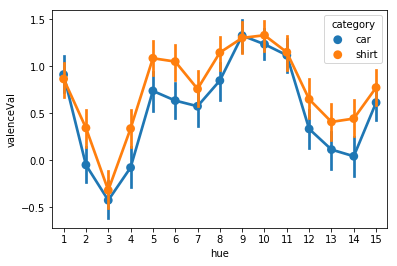

In [193]:
sns.pointplot(x='hue',y='valenceVal',hue='category',data=allVal)

Mean valence of the assocations as a function of the hue, across two categories.

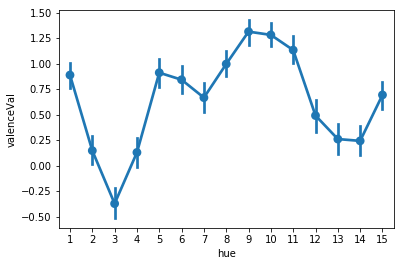

In [194]:
sns.pointplot(x='hue',y='valenceVal',data=allVal)

Mean valence of the assocation averaged over categories

In [199]:
shirts_allVal_valmean=allVal.sort_values(by=['subnum','hue']).groupby('category').get_group('shirt')
cars_allVal_valmean=allVal.sort_values(by=['subnum','hue']).groupby('category').get_group('car')

In [200]:
shirts_allVal_valmean.head()

,association,hue,wordN,subname,category,valence,valenceN,valenceVal,subnum
3,autumn,1,1,sub1,shirt,Slightly Positive,1,1,1
4,fire,1,2,sub1,shirt,Slightly Positive,2,1,1
5,warm,1,3,sub1,shirt,Slightly Positive,3,1,1
9,rust,2,1,sub1,shirt,Slightly Negative,1,-1,1
10,dogs,2,2,sub1,shirt,Slightly Positive,2,1,1


In [208]:
cars_allVal_valmean.groupby(['subnum','hue']).agg({'valenceVal':'mean'})

valenceVal
subnum hue            
1      1      0.333333
       2      0.333333
       3      0.000000
       4     -0.666667
       5      1.000000
...                ...
96     11     1.000000
       12    -0.333333
       13     1.000000
       14     2.000000
       15     2.000000

[1410 rows x 1 columns]

In [280]:
meanValDF=pd.concat([shirts_allVal_valmean.groupby(['subnum','hue']).agg({'valenceVal':'mean'}),
 cars_allVal_valmean.groupby(['subnum','hue']).agg({'valenceVal':'mean'})])

## Read counts info

In [268]:
allCountsSummary=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allCountsSummary.csv")

In [269]:
allCountsSummary.head()

,subnum,category,hue,count,fixed_diff,consecutive_diff
0,1,Shirts,1,18,1.2,1.4
1,1,Shirts,2,9,1.8,2.0
2,1,Shirts,3,4,0.4,0.4
3,1,Shirts,4,14,1.2,1.4
4,1,Shirts,5,32,1.2,1.0


In [270]:
set(allCountsSummary.subnum)-set(allVal.subnum)

{8, 55}

In [240]:
finSubs['sub8'].subname#here is one that was removed, don't have previous data for it??

'sub9'

In [271]:
allCountsSummary=allCountsSummary[allCountsSummary['subnum']!=8]
allCountsSummary=allCountsSummary[allCountsSummary['subnum']!=55]
allCountsSummary=allCountsSummary[allCountsSummary['category']!='Phones']

In [272]:
allCountsSummary.reset_index(drop=True,inplace=True)

In [273]:
len(np.unique(allCountsSummary.subnum))

94

In [300]:
allCountsSummary['meanValence']=np.round(meanValDF.valenceVal.values)

In [301]:
allCountsSummary.head()

,subnum,category,hue,count,fixed_diff,consecutive_diff,meanValence
0,1,Shirts,1,18,1.2,1.4,1.0
1,1,Shirts,2,9,1.8,2.0,0.0
2,1,Shirts,3,4,0.4,0.4,-1.0
3,1,Shirts,4,14,1.2,1.4,1.0
4,1,Shirts,5,32,1.2,1.0,1.0


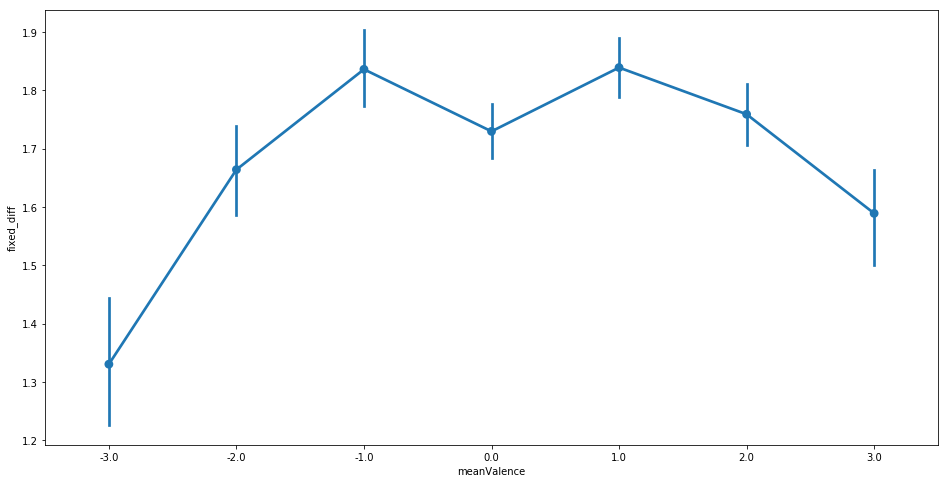

In [304]:
plt.rcParams['figure.figsize'] = [16, 8]
sns.pointplot(allCountsSummary.meanValence,allCountsSummary.fixed_diff,ci=68)
# sns.pointplot(allCountsSummary.meanValence,allCountsSummary.consecutive_diff,color='r')


Relationship between mean valence of different items and how much subjects changed in their preferences for that item. An inverted U shape curve is seen, therefore, those objects with very negative or very positive valences were less likely to change than those who are neutral.